# Benchmark: MBR computation

Benchmark comparing Minimum Bounding Rectangle computation across:

* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

## Benchmarked operation

Each iteration computes the Minimum Bounding Rectangle of the multi-polygon representing all districts of India a 100,000 times.

# Prerequisites

Generate data:

```sh
cd harness
cargo run --release --bin benchmark_mbr -- --out-file ../analysis/benchmark_mbr/data.json --geojson-file ../data/india_districts/polbnda_ind.geojson
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_mbr/data.json
### Statistics: Raw data
                 qps              
program          geo          geos
count     200.000000    200.000000
mean     5550.317836  55367.773295
std       281.094298   3606.390789
min      4276.468012  26469.556000
25%      5570.342278  55400.197247
50%      5651.474461  55922.151577
75%      5682.716308  56699.409455
max      5823.625922  59008.883256


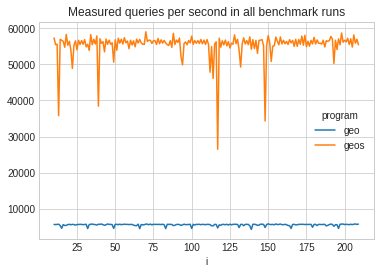

### Statistics: After outlier removal
                 qps              
program          geo          geos
count     183.000000    183.000000
mean     5617.853110  55927.796110
std       118.202076   1476.026990
min      5138.668221  48860.425845
25%      5582.556741  55442.771607
50%      5657.616506  56012.665584
75%      5684.096046  56701.394668
max      5823.625922  59008.883256


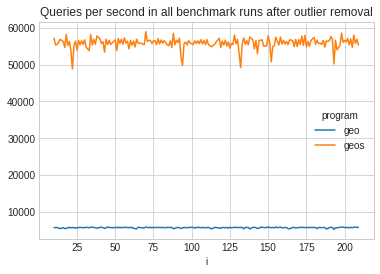

## Ratio of qps compared to geo
                qps
program        geos
count    183.000000
mean       9.959191
std        0.320604
min        8.625706
25%        9.781346
50%        9.949043
75%       10.106615
max       10.992722


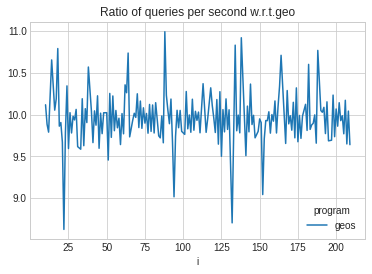

In [2]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb

# Performance benchmarking

To generate the following SVG:

```bash
cd harness
cargo build --release

perf record -F 990 -g -o ../analysis/benchmark_mbr/perf.data -- ./target/release/benchmark_mbr --geojson-file ../data/india_districts/polbnda_ind.geojson --out-file /dev/null --iterations 200 --headlong > /dev/null

cd ../analysis/benchmark_mbr
perf script -i perf.data | ../../third_party/stackcollapse-perf.pl > perf.collapsed-stacks.data
../../third_party/flamegraph.pl perf.collapsed-stacks.data > perf.svg
```

![](./perf.svg)

To dig in further, use
```
perf report -g -i perf.data
```

This shows that over 90% time is spent in `geo_types::private_utils::get_bounding_rect`.

In particular, `getEnvelope` in `libgeos` contributes ~0.13% time: ![](./ReportGetEnvelope.png)

-> My assumption that geo is losing out due to bad memory allocations is wrong.